In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [22]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import tensorflow_addons as tfa
import numpy as np
import IPython.display as display
import matplotlib.pyplot as plt
import glob
import zipfile
import cv2
from PIL import Image, ImageDraw
from datetime import datetime
import random

In [23]:
is_colab = False
is_production = True

In [24]:
tf.random.set_seed(0)
random.seed(0)


In [25]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version: ", tf.__version__)

Num GPUs Available:  1
TensorFlow version:  2.15.0


In [26]:
def parse_tfrecord_fn(example_proto):
    # Define the feature description for parsing
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'steering': tf.io.FixedLenFeature([], tf.float32),
    }

    # Parse the example
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    steering = parsed_features['steering']
    image = tf.image.decode_jpeg(parsed_features['image'], channels=3)
    image = tf.cast(image, tf.float32)
    # Resize the image
    image = tf.image.resize(image, [224, 224])
    # Normalize the image
    image = image / 255.0
    
    return image, steering


In [27]:
def load_dataset(tfrecord_files):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)
    return raw_dataset.map(parse_tfrecord_fn)

In [28]:
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    if not os.path.exists("datasets"):
        os.makedirs("datasets")
    
    path_to_zip_file = "/content/drive/MyDrive/Colab Notebooks/AD/datasets/dataset_2024-04-0.zip"
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall("./datasets")

    tfrecord_files = list(glob.glob("./datasets/*.tfrecord"))
else:
    tfrecord_files = list(glob.glob("/home/anaya/Develop/autonomous_driving_training/datasets/*.tfrecord"))

In [29]:
def get_model():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    return tf.keras.Sequential([
        base_model,
        # Flatten the output to feed into the dense layers
        layers.Flatten(),
        layers.Dropout(0.5),
    
        # Second fully connected layer
        layers.Dense(100, activation='relu'),
        layers.BatchNormalization(),
    
        # Third fully connected layer
        layers.Dense(50, activation='relu'),
        layers.BatchNormalization(),
    
        # Fourth fully connected layer
        layers.Dense(10, activation='relu'),
    
        # Output layer
        layers.Dense(1)
    ])

In [30]:

parsed_dataset = load_dataset(tfrecord_files)
shuffled_dataset = parsed_dataset.shuffle(2040)

# Determine split sizes
total_items = sum([1 for _ in shuffled_dataset.as_numpy_iterator()])
train_size = int(0.6 * total_items)
val_size = int(0.2 * total_items)
test_size = total_items - train_size - val_size


In [31]:
print("Total items: ", total_items)
print("Train size: ", train_size)
print("Validation size: ", val_size)
print("Test size: ", test_size)

Total items:  59514
Train size:  35708
Validation size:  11902
Test size:  11904


In [32]:
# NOTE - Restart experiment from here

if not is_production:
    tf.random.set_seed(0)
    random.seed(0)

# Split the dataset
train_dataset = shuffled_dataset.take(train_size)
test_val_dataset = shuffled_dataset.skip(train_size)
val_dataset = test_val_dataset.take(val_size)
test_dataset = test_val_dataset.skip(val_size)

In [33]:
# Apply any additional preprocessing here (e.g., batching)
batch_size = 40
train_dataset = train_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)


In [34]:
# Create a sequential model
model = get_model()

# Summary of the model to see the structure and parameters
# model.summary()


In [35]:
def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.1
    else:
        return lr

callback_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [36]:
from tensorflow.keras import backend as K

def steering_accuracy(threshold=0.05):
    def SA(y_true, y_pred):
        return K.mean(K.cast(K.less_equal(K.abs(y_true - y_pred), threshold), K.floatx()))
    return SA

tf.Tensor(0.2246, shape=(), dtype=float32)


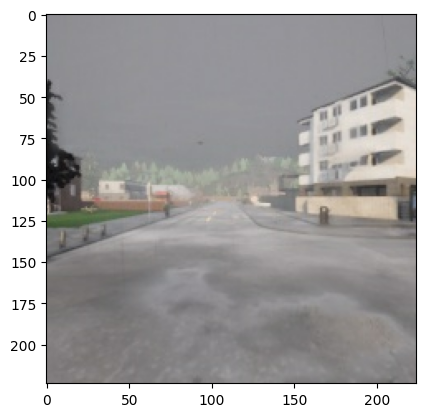

In [37]:
for data_row in train_dataset.take(1):
    print(data_row[1][0])
    image = data_row[0][0].numpy()
    plt.imshow(image)


In [38]:
train_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, min_delta=0.0005)
val_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0005)

In [39]:
# Compile the model (make sure to specify the loss and optimizer)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[steering_accuracy(threshold=0.05)],
)


In [40]:
log_dir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [41]:
# Step 5: Train the Model
# tf.random.set_seed(0)
# random.seed(0)

with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=val_dataset,
        callbacks=[
            callback_lr_scheduler,
            train_early_stopping,
            val_early_stopping,
            tensorboard_callback
        ],
        verbose=1
    )

Epoch 1/50


I0000 00:00:1713568370.604709  335913 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


892/892 [==============================] - 86s 91ms/step - loss: 0.0734 - SA: 0.2482 - val_loss: 0.0154 - val_SA: 0.4516 - lr: 0.0010
Epoch 2/50
892/892 [==============================] - 81s 91ms/step - loss: 0.0154 - SA: 0.4121 - val_loss: 0.0140 - val_SA: 0.4651 - lr: 0.0010
Epoch 3/50
892/892 [==============================] - 81s 91ms/step - loss: 0.0112 - SA: 0.4716 - val_loss: 0.0123 - val_SA: 0.4842 - lr: 0.0010
Epoch 4/50
892/892 [==============================] - 81s 91ms/step - loss: 0.0086 - SA: 0.5191 - val_loss: 0.0113 - val_SA: 0.5315 - lr: 0.0010
Epoch 5/50
892/892 [==============================] - 81s 91ms/step - loss: 0.0076 - SA: 0.5477 - val_loss: 0.0144 - val_SA: 0.4647 - lr: 0.0010
Epoch 6/50
892/892 [==============================] - 81s 91ms/step - loss: 0.0074 - SA: 0.5504 - val_loss: 0.0120 - val_SA: 0.5359 - lr: 1.0000e-04
Epoch 7/50
892/892 [==============================] - 81s 91ms/step - loss: 0.0065 - SA: 0.5737 - val_loss: 0.0140 - val_SA: 0.5163 - lr:

In [42]:
# Step 6: Evaluate the Model
model.evaluate(test_dataset, callbacks=[tensorboard_callback], verbose=1)

297/297 [==============================] - 21s 66ms/step - loss: 0.0191 - SA: 0.4871


[0.019128113985061646, 0.4871212840080261]

In [43]:
if is_production:
    import tf2onnx
    import onnx
    
    # Export model to ONNX
    current_date = datetime.now().strftime("%Y%m%d-%H%M%S")
    model.save(f"save/model_{current_date}.h5")
    
    input_signature = [
        tf.TensorSpec((1, 224, 224, 3), dtype=tf.float32, name="x")
    ]
    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)
    onnx.save(onnx_model, f"save/model_{current_date}.onnx")
    

/home/anaya/anaconda3/envs/av_training/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
# %load_ext tensorboard

In [45]:
# %tensorboard --logdir ./logs/fit/